In [4]:
#conda activate torch-xla-nightly
#export XRT_TPU_CONFIG="tpu_worker;0;$10.0.101.2:8470"
#git init
#git remote add origin https://github.com/nosound2/RSNA-Hemorrhage
#git pull origin master
#git config remote.origin.push HEAD
#gcloud config set compute/zone europe-west4-a
#gcloud auth login
#gcloud config set project endless-empire-239015
#pip install kaggle
#mkdir .kaggle
#gsutil cp gs://recursion-double-strand/kaggle-keys/kaggle.json ~/.kaggle
#chmod 600 /home/zahar_chikishev/.kaggle/kaggle.json
#kaggle competitions download rsna-intracranial-hemorrhage-detection -f stage_1_train.csv
#sudo apt install unzip
#unzip stage_1_train.csv.zip
#kaggle kernels output xhlulu/rsna-generate-metadata-csvs -p .
#gsutil cp gs://rsna-hemorrhage/yuvals/* .

#export XRT_TPU_CONFIG="tpu_worker;0;10.0.101.2:8470"; conda activate torch-xla-nightly; jupyter notebook

# 35.204.242.164

In [1]:
VERSION = 75
CLOUD_SINGLE = False
MIXUP = False
DATA_SET = 2
NO_BLACK_LOSS = True

if DATA_SET == 1:
    dataset_name = 'Densenet161'
    feat_sz = 2208
elif DATA_SET == 2:
    dataset_name = 'Densenet169'
    filename_add = '_3'
    filename_add2 = '_v3'
    feat_sz = 208
elif DATA_SET == 3:
    dataset_name = 'Densenet201'
    filename_add = '_3'
    filename_add2 = '_v3'
    feat_sz = 240
elif DATA_SET == 4:
    dataset_name = 'se_resnext101_32x4d'
    filename_add = ''
    filename_add2 = ''
    feat_sz = 256
elif DATA_SET == 5:
    dataset_name = 'Densenet161'
    filename_add = '_3'
    filename_add2 = '_v4'
    feat_sz = 552
else: assert False

In [2]:
import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,log_loss,roc_auc_score
from scipy.stats import ks_2samp

import pdb

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob

import torch

CLOUD = not torch.cuda.is_available()

if not CLOUD:
    torch.cuda.current_device()

import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torch.utils as U

import torchvision
from torchvision import transforms as T
from torchvision import models as M

import matplotlib.pyplot as plt

if CLOUD:
    PATH = Path('/home/zahar_chikishev')
    PATH_WORK = Path('/home/zahar_chikishev/running')
else:
    PATH = Path('C:/StudioProjects/Hemorrhage')
    PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
class_weights = 6.0*np.array([2,1,1,1,1,1])/7.0

if CLOUD:
    import torch_xla
    import torch_xla.distributed.data_parallel as dp
    import torch_xla.utils as xu
    import torch_xla.core.xla_model as xm
    
    from typing import Collection

In [3]:
all_black = '006d4432e'
all_black = '00bd6c59c'

if CLOUD:
    device = xm.xla_device()
    #device = 'cpu'
    MAX_DEVICES = 1 if CLOUD_SINGLE else 8
    bs = 32
else:
    device = 'cuda'
    #device = 'cpu'
    MAX_DEVICES = 1
    bs = 16

if CLOUD and (not CLOUD_SINGLE):
    devices = xm.get_xla_supported_devices(max_devices=MAX_DEVICES)

In [4]:
SEED = 2351

def setSeeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

setSeeds(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
cols_le,cols_float,cols_bool = pickle.load(open(PATH_WORK/'covs','rb'))
meta_cols = cols_bool + cols_float

In [6]:
#meta_cols = ['ImagePositionPatient_1','pos_rel']

In [7]:
if DATA_SET == 1:
    if False:
        filename = PATH_WORK/'indexes_file.pkl'
        all_idx, train_ids, val_ids = pickle.load(open(filename,'rb'))

        train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        ids_df = pd.DataFrame(all_idx, columns = ['img_id'])
        ids_df = ids_df.join(train_md.set_index('img_id'), on = 'img_id')
        
        assert len(ids_df.SeriesInstanceUID.unique()) == 19530
        
        trn_data = ids_df.loc[ids_df.img_id.isin(all_idx[train_ids])].reset_index(drop=True)
        val_data = ids_df.loc[ids_df.img_id.isin(all_idx[val_ids])].reset_index(drop=True)

        assert len(trn_data.SeriesInstanceUID.unique()) + len(val_data.SeriesInstanceUID.unique()) \
            == len(train_md.SeriesInstanceUID.unique())

        assert len(trn_data.PatientID.unique()) + len(val_data.PatientID.unique()) \
            >= len(train_md.PatientID.unique())

        pickle.dump((trn_data,val_data), open(PATH_WORK/'train.post.processed.1','wb'))
    else:
        trn_data,val_data = pickle.load(open(PATH_WORK/'train.post.processed.1','rb'))

In [8]:
if DATA_SET == 1:
    if False:
        test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        filename = PATH_WORK/'test_indexes.pkl'
        test_ids = pickle.load(open(filename,'rb'))

        test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
        test_md = test_ids_df.join(test_md.set_index('img_id'), on = 'img_id')

        assert len(test_md.SeriesInstanceUID.unique()) == 2214

        pickle.dump(test_md, open(PATH_WORK/'test.post.processed.1','wb'))
    else:
        test_md = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))

In [9]:
if False:
    print(pd.concat([test_md[meta_cols].mean(0),
                     trn_data[meta_cols].mean(0),
                     val_data[meta_cols].mean(0)], axis=1))

# Pre-processing

In [12]:
if DATA_SET >= 2:
    if False:
        train_dedup = pd.read_csv(PATH_WORK/'yuval'/'train_dedup.csv')
        pids, folding = pickle.load(open(PATH_WORK/'yuval'/'PID_splits.pkl','rb'))

        assert len(pids) == 17079
        assert len(np.unique(pids)) == 17079

        for fol in folding:
            assert len(fol[0]) + len(fol[1]) == 17079

        assert len(folding[0][1]) + len(folding[1][1]) + len(folding[2][1]) == 17079

        assert len(train_dedup.PID.unique()) == 17079

        train_dedup['fold'] = np.nan

        for fold in range(3):
            train_dedup.loc[train_dedup.PID.isin(pids[folding[fold][1]]),'fold'] = fold

        assert train_dedup.fold.isnull().sum() == 0

        train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        ids_df = train_dedup[['fold','PatientID']]
        ids_df.columns = ['fold','img_id']

        ids_df = ids_df.join(train_md.set_index('img_id'), on = 'img_id')

        pickle.dump(ids_df, open(PATH_WORK/'features/{}{}/train/train.ids.df'.format(dataset_name, filename_add2),'wb'))

        #test_md = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))
        test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])
        
        filename = PATH_WORK/'test_indexes.pkl'
        test_ids = pickle.load(open(filename,'rb'))

        test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
        test_md = test_ids_df.join(test_md.set_index('img_id'), on = 'img_id')
        
        assert len(test_md.SeriesInstanceUID.unique()) == 2214
        
        pickle.dump(test_md, open(PATH_WORK/'features/{}{}/test/test.ids.df'.format(dataset_name,filename_add2),'wb'))

        for fold in range(3):
            filename = PATH_WORK/'yuval'/\
                'model_{}{}_version_classifier_splits_type_features_train_tta_split_{}.pkl'\
                .format(dataset_name, filename_add, fold)
            feats = pickle.load(open(filename,'rb'))
            print('feats size', feats.shape)
            assert len(feats) == 4*len(ids_df)
            means = feats.mean(0,keepdim=True)
            stds = feats.std(0,keepdim=True)
            
            feats = feats - means
            feats = torch.where(stds > 0, feats/stds, feats)

            for i in range(4):
                feats_sub1 = feats[torch.BoolTensor(np.arange(len(feats))%4 == i)]
                feats_sub2 = feats_sub1[torch.BoolTensor(train_dedup.fold != fold)]
                pickle.dump(feats_sub2, open(PATH_WORK/'features/{}{}/train/train.f{}.a{}'
                                             .format(dataset_name,filename_add2,fold,i),'wb'))

                feats_sub2 = feats_sub1[torch.BoolTensor(train_dedup.fold == fold)]
                pickle.dump(feats_sub2, open(PATH_WORK/'features/{}{}/train/valid.f{}.a{}'
                                             .format(dataset_name,filename_add2,fold,i),'wb'))

                if i==0:
                    black_feats = feats_sub1[torch.BoolTensor(ids_df.img_id == all_black)].squeeze()
                    pickle.dump(black_feats, open(PATH_WORK/'features/{}{}/train/black.f{}'
                                                  .format(dataset_name,filename_add2,fold),'wb'))

            filename = PATH_WORK/'yuval'/\
                'model_{}{}_version_classifier_splits_type_features_test_split_{}.pkl'\
                .format(dataset_name,filename_add,fold)
            feats = pickle.load(open(filename,'rb'))
            
            feats = feats - means
            feats = torch.where(stds > 0, feats/stds, feats)
            
            for i in range(8):
                feats_sub = feats[torch.BoolTensor(np.arange(len(feats))%8 == i)]
                pickle.dump(feats_sub, open(PATH_WORK/'features/{}{}/test/test.f{}.a{}'
                                            .format(dataset_name,filename_add2,fold,i),'wb'))
                assert len(feats_sub) == len(test_md)
    else:
        ids_df = pickle.load(open(PATH_WORK/'features/{}{}/train/train.ids.df'.format(dataset_name,filename_add2),'rb'))
        test_md = pickle.load(open(PATH_WORK/'features/{}{}/test/test.ids.df'.format(dataset_name,filename_add2),'rb'))

feats size torch.Size([2697008, 208])
feats size torch.Size([2697008, 208])
feats size torch.Size([2697008, 208])


In [39]:
if DATA_SET == 1:
    if False:
        filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_train_split_2.pkl'
        feats = pickle.load(open(filename,'rb'))

        for series_id in tqdm(ids_df.SeriesInstanceUID.unique()):
            mask = torch.BoolTensor(ids_df.SeriesInstanceUID.values == series_id)
            feats_id = feats[mask]
            pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/train/{}'.format(series_id),'wb'))


        filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_test_split_2.pkl'
        feats = pickle.load(open(filename,'rb'))

        for series_id in tqdm(test_md.SeriesInstanceUID.unique()):
            mask = torch.BoolTensor(test_md.SeriesInstanceUID.values == series_id)
            feats_id = feats[mask]
            pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/test/{}'.format(series_id),'wb'))

# Dataset

In [14]:
#path = PATH_WORK/'features/densenet161_v3/train/ID_000a935543'
#feats1 = pickle.load(open(path,'rb'))

In [15]:
#ff = pickle.load(open(PATH_WORK/'features/{}{}/{}/{}.f{}.a{}'\
#                .format(dataset_name,filename_add2,'train','train',0,0),'rb'))

In [16]:
if DATA_SET == 1:
    path = PATH_WORK/'features/densenet161_v3/train/ID_992b567eb6'
    black_feats = pickle.load(open(path,'rb'))[41]

In [17]:
class RSNA_DataSet(D.Dataset):
    def __init__(self, metadata, mode='train', bs=None, dataset=DATA_SET, fold=0):
        
        super(RSNA_DataSet, self).__init__()
        
        if dataset == 1:
            md = metadata.copy()
            md = md.reset_index(drop=True)
        else:
            if mode == 'train':
                md = metadata.loc[metadata.fold != fold].copy().reset_index(drop=True)
            elif mode == 'valid':
                md = metadata.loc[metadata.fold == fold].copy().reset_index(drop=True)
            else:
                md = metadata.copy().reset_index(drop=True)
        
        series = np.sort(md.SeriesInstanceUID.unique())
        md = md.set_index('SeriesInstanceUID', drop=True)
        
        samples_add = 0
        if (mode != 'train') and not DATA_SMALL:
            batch_num = -((-len(series))//(bs*MAX_DEVICES))
            samples_add = batch_num*bs*MAX_DEVICES - len(series)
            print('adding dummy serieses', samples_add)
        
        #self.records = df.to_records(index=False)
        self.mode = mode
        self.real = np.concatenate([np.repeat(True,len(series)),np.repeat(False,samples_add)])
        self.series = np.concatenate([series, random.sample(list(series),samples_add)])
        self.metadata = md
        self.dataset = dataset
        self.fold = fold
        
        print('DataSet', dataset, mode, 'size', len(self.series), 'fold', fold)
        
        if self.dataset >= 2:
            path = PATH_WORK/'features/{}{}/train/black.f{}'.format(dataset_name, filename_add2, fold)
            self.black_feats = pickle.load(open(path,'rb')).squeeze()
        
        elif self.dataset == 1:
            self.black_feats = black_feats
    
    def setFeats(self, anum):
        def getAPath(an):
            return PATH_WORK/'features/{}{}/{}/{}.f{}.a{}'\
                .format(dataset_name,filename_add2,folder,self.mode,self.fold,an)
        
        if self.dataset == 1: return
        print('setFeats, augmentation', anum)
        self.anum = anum
        folder = 'test' if self.mode == 'test' else 'train'
        sz = len(self.metadata)
        if anum == -1:
            max_a = 8 if self.mode == 'test' else 4
            feats2 = torch.stack([pickle.load(open(getAPath(an),'rb')) for an in range(max_a)])
            feats = feats2[torch.randint(max_a,(sz,)), torch.arange(sz)].squeeze()
        else:
            feats = pickle.load(open(getAPath(anum),'rb'))
        
        self.feats = feats
        assert len(feats) == sz
    
    def __getitem__(self, index):
        
        series_id = self.series[index]
        #df = self.metadata.loc[self.metadata.SeriesInstanceUID == series_id].reset_index(drop=True)
        df = self.metadata.loc[series_id].reset_index(drop=True)
        
        if self.dataset == 1:
            folder = 'test' if self.mode == 'test' else 'train'
            path = PATH_WORK/'features/densenet161_v3/{}/{}'.format(folder,series_id)
            feats = pickle.load(open(path,'rb'))
            
            if feats.shape[0] > len(df.img_id.unique()):
                mask_dup = ~df.img_id.duplicated().values
                df = df.loc[mask_dup]
                feats = feats[torch.BoolTensor(mask_dup)]
            
            assert feats.shape[0] == len(df)
        elif self.dataset >= 2:
            feats = self.feats[torch.BoolTensor(self.metadata.index.values == series_id)]
        else: assert False
        
        order = np.argsort(df.pos_idx1.values)
        df = df.sort_values(['pos_idx1'])
        feats = feats[torch.LongTensor(order)]
        
        non_black = torch.ones(len(feats))
        feats = torch.cat([feats, torch.Tensor(df[meta_cols].values)], dim=1)
        feats_le = torch.LongTensor(df[cols_le].values)
        
        target = torch.Tensor(df[all_ich].values)
        
        #PAD = 4+9+1
        PAD = 8
        
        offset = np.random.randint(0, 61 - feats.shape[0])
        #offset = 0
        top_pad = PAD + offset
        if top_pad > 0:
            dummy_row = torch.cat([self.black_feats, torch.Tensor(df.head(1)[meta_cols].values).squeeze()])
            feats = torch.cat([dummy_row.repeat(top_pad,1), feats], dim=0)
            feats_le = torch.cat([torch.LongTensor(df.head(1)[cols_le].values).squeeze().repeat(top_pad,1), feats_le])
            if offset > 0:
                non_black = torch.cat([0.01 + torch.zeros(offset), non_black])
                target = torch.cat([torch.zeros((offset, len(all_ich))), target], dim=0)
        bot_pad = 60 - len(df) - offset + PAD
        if bot_pad > 0:
            dummy_row = torch.cat([self.black_feats, torch.Tensor(df.tail(1)[meta_cols].values).squeeze()])
            feats = torch.cat([feats, dummy_row.repeat(bot_pad,1)], dim=0)
            feats_le = torch.cat([feats_le, torch.LongTensor(df.tail(1)[cols_le].values).squeeze().repeat(bot_pad,1)])
            if (60 - len(df) - offset) > 0:
                non_black = torch.cat([non_black, 0.01 + torch.zeros(60 - len(df) - offset)])
                target = torch.cat([target, torch.zeros((60 - len(df) - offset, len(all_ich)))], dim=0)
        
        assert feats_le.shape[0] == (60 + 2*PAD)
        assert feats.shape[0] == (60 + 2*PAD)
        assert target.shape[0] == 60
        
        #feats = feats.transpose(1,0)
        
        idx = index
        if not self.real[index]: idx = -1
        
        if self.mode == 'train':
            return feats, feats_le, target, non_black
        else:
            return feats, feats_le, target, idx, offset
    
    def __len__(self):
        return len(self.series) if not DATA_SMALL else int(0.01*len(self.series))

In [18]:
def getCurrentBatch(fold=0):
    sel_batch = None
    for filename in os.listdir(PATH_WORK/'models'):
        splits = filename.split('.')
        if int(splits[2][1]) != fold: continue
        if int(splits[3][1:]) != VERSION: continue
        if sel_batch is None:
            sel_batch = int(splits[1][1:])
        else:
            sel_batch = max(sel_batch, int(splits[1][1:]))
    return sel_batch

def modelFileName(fold=0, batch = 1, return_last = False, return_next = False):
    sel_batch = batch
    if return_last or return_next:
        sel_batch = getCurrentBatch(fold)
        if return_last and sel_batch is None:
            return None
        if return_next:
            if sel_batch is None: sel_batch = 1
            else: sel_batch += 1
    
    return 'model.b{}.f{}.v{}'.format(sel_batch, fold, VERSION)

# Model

In [19]:
class BCEWithLogitsLoss(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    
    def forward(self, input, target, batch_weights = None):
        loss = (torch.log(1+torch.exp(input)) - target*input)*self.weight
        if batch_weights is not None:
            loss = batch_weights*loss
        return loss.mean()

In [20]:
def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

In [21]:
def noop(x): return x
act_fun = nn.ReLU(inplace=True)

def conv_layer(ni, nf, ks=3, act=True):
    bn = nn.BatchNorm1d(nf)
    layers = [nn.Conv1d(ni, nf, ks), bn]
    if act: layers.append(act_fun)
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, ni, nh):
        super().__init__()
        layers  = [conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 5, act=False)]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if (ni == nh) else conv_layer(ni, nh, 1, act=False)
    
    def forward(self, x): return act_fun(self.convs(x) + self.idconv(x[:,:,2:-2]))

In [22]:
class ResNetModel(nn.Module):
    def __init__(self, n_cont:int, feat_sz=2208):
        super().__init__()
        
        self.le_sz = 9
        le_in_sizes = np.array([5,5,7,4,4,11,4,6,3])
        le_out_sizes = np.array([3,3,4,2,2,6,2,4,2])
        le_out_sz = le_out_sizes.sum()
        self.embeddings = nn.ModuleList([embedding(le_in_sizes[i], le_out_sizes[i]) for i in range(self.le_sz)])

        self.feat_sz = feat_sz
        
        self.n_cont = n_cont
        
        self.conv2D = nn.Conv2d(1,64,(feat_sz + n_cont + le_out_sz,1))
        self.bn1 = nn.BatchNorm1d(64)
        
        self.res1 = ResBlock(64,64)
        self.res2 = ResBlock(64,64)
        self.res3 = ResBlock(64,64)
        self.res4 = ResBlock(64,64)
        
        self.conv1D = nn.Conv1d(128,6,1)
    
    def forward(self, x, x_le, x_le_mix = None, lambd = None) -> torch.Tensor:
        x_le = [e(x_le[:,:,i]) for i,e in enumerate(self.embeddings)]
        x_le = torch.cat(x_le, 2)
        
        x = torch.cat([x, x_le], 2)
        x = x.transpose(1,2)
        
        #x = torch.cat([x[:,:self.feat_sz],self.bn_cont(x[:,self.feat_sz:])], dim=1)
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        
        x = self.conv2D(x).squeeze()
        x = self.bn1(x)
        x = act_fun(x)
        
        x2 = self.res1(x)
        x2 = self.res2(x2)
        x2 = self.res3(x2)
        x2 = self.res4(x2)
        
        x = torch.cat([x[:,:,8:-8], x2], 1)
        x = self.conv1D(x)
        x = x.transpose(1,2)
        
        return x

In [23]:
def trunc_normal_(x, mean:float=0., std:float=1.):
    "Truncated normal initialization."
    # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    return x.normal_().fmod_(2).mul_(std).add_(mean)

In [24]:
def embedding(ni:int,nf:int) -> nn.Module:
    "Create an embedding layer."
    emb = nn.Embedding(ni, nf)
    # See https://arxiv.org/abs/1711.09160
    with torch.no_grad(): trunc_normal_(emb.weight, std=0.01)
    return emb

In [25]:
class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, n_cont:int, feat_sz=2208, fc_drop_p=0.3):
        super().__init__()
        self.le_sz = 9
        le_in_sizes = np.array([5,5,7,4,4,11,4,6,3])
        le_out_sizes = np.array([3,3,4,2,2,6,2,4,2])
        le_out_sz = le_out_sizes.sum()
        self.embeddings = nn.ModuleList([embedding(le_in_sizes[i], le_out_sizes[i]) for i in range(self.le_sz)])
        #self.bn_cont = nn.BatchNorm1d(feat_sz + n_cont)
        
        self.feat_sz = feat_sz
        self.bn_cont = nn.BatchNorm1d(n_cont + le_out_sz)
        self.n_cont = n_cont
        self.fc_drop = nn.Dropout(p=fc_drop_p)
        self.relu = nn.ReLU(inplace=True)
        
        scale = 4
        
        self.conv2D_1 = nn.Conv2d(1,16*scale,(feat_sz + n_cont + le_out_sz,1))
        self.conv2D_2 = nn.Conv2d(1,16*scale,(feat_sz + n_cont + le_out_sz,5))
        self.bn_cont1 = nn.BatchNorm1d(32*scale)
        self.conv1D_1 = nn.Conv1d(32*scale,16*scale,3)
        self.conv1D_3 = nn.Conv1d(32*scale,16*scale,5,dilation=5)
        self.conv1D_2 = nn.Conv1d(32*scale,6,3)
        self.bn_cont2 = nn.BatchNorm1d(32*scale)
        self.bn_cont3 = nn.BatchNorm1d(6)

        self.conv1D_4 = nn.Conv1d(32*scale,32*scale,3)
        self.bn_cont4 = nn.BatchNorm1d(32*scale)

    def forward(self, x, x_le, x_le_mix = None, lambd = None) -> torch.Tensor:
        x_le = [e(x_le[:,:,i]) for i,e in enumerate(self.embeddings)]
        x_le = torch.cat(x_le, 2)
        
        if MIXUP and x_le_mix is not None:
            x_le_mix = [e(x_le_mix[:,:,i]) for i,e in enumerate(self.embeddings)]
            x_le_mix = torch.cat(x_le_mix, 2)
            x_le = lambd * x_le + (1-lambd) * x_le_mix
        
        #assert torch.isnan(x_le).any().cpu() == False
        x = torch.cat([x, x_le], 2)
        x = x.transpose(1,2)
        
        #x = torch.cat([x[:,:self.feat_sz],self.bn_cont(x[:,self.feat_sz:])], dim=1)
        
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        x = self.fc_drop(x)
        x = torch.cat([self.conv2D_1(x[:,:,:,2:(-2)]).squeeze(), 
                       self.conv2D_2(x).squeeze()], dim=1)
        x = self.relu(x)
        x = self.bn_cont1(x)
        x = self.fc_drop(x)
        
        x = torch.cat([self.conv1D_1(x[:,:,9:(-9)]),
                       self.conv1D_3(x)], dim=1)
        x = self.relu(x)
        x = self.bn_cont2(x)
        x = self.fc_drop(x)
        
        x = self.conv1D_4(x)
        x = self.relu(x)
        x = self.bn_cont4(x)
        
        x = self.conv1D_2(x)
        x = x.transpose(1,2)
        
        return x

# Training

In [26]:
def train_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 4
        generator = loader
        device_num = int(str(device)[-1])
        dataset = loader._loader._loader.dataset
    else:
        tlen = len(loader)
        OUT_LOSS = 10
        OUT_TIME = 1
        generator = enumerate(loader)
        device_num = 1
        dataset = loader.dataset
    
    #print('Start training {}'.format(device), 'batches', tlen)
    
    criterion = BCEWithLogitsLoss(weight = torch.Tensor(class_weights).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.99))
    
    model.train()
    
    if CLOUD:
        tracker = xm.RateTracker()

    tloss = 0
    tloss_count = 0
    
    st = time.time()
    mixup_collected = False
    x_le_mix = None
    lambd = None
    for i, (x, x_le, y, non_black) in generator:
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            x_le = x_le.to(device)
            y = y.to(device)
            non_black = non_black.to(device)
        
        if MIXUP:
            if mixup_collected:
                lambd = np.random.beta(0.4, 0.4, y.size(0))
                lambd = torch.Tensor(lambd).to(device)[:,None,None]
                #shuffle = torch.randperm(y.size(0)).to(device)
                x = lambd * x + (1-lambd) * x_mix #x[shuffle]
                #x_le = lambd * x_le + (1-lambd) * x_le_mix #x[shuffle]
                mixup_collected = False
            else:
                x_mix = x
                x_le_mix = x_le
                y_mix = y
                mixup_collected = True
                continue
        
        optimizer.zero_grad()
        output = model(x, x_le, x_le_mix, lambd)
        
        if MIXUP:
            if NO_BLACK_LOSS:
                loss = criterion(output, y, lambd*non_black[:,:,None]) \
                     + criterion(output, y_mix, (1-lambd)*non_black[:,:,None])
            else:
                loss = criterion(output, y, lambd) + criterion(output, y_mix, 1-lambd)
            del x_mix, y_mix
        else:
            if NO_BLACK_LOSS:
                loss = criterion(output, y, non_black[:,:,None])
            else:
                loss = criterion(output, y)
        
        loss.backward()
        
        tloss += len(y)*loss.cpu().detach().item()
        tloss_count += len(y)
        
        if CLOUD or CLOUD_SINGLE:
            xm.optimizer_step(optimizer)
            if CLOUD_SINGLE:
                xm.mark_step()
        else:
            optimizer.step()
        
        if CLOUD:
            tracker.add(len(y))
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            #print(torch_xla._XLAC._xla_metrics_report())
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del loss, output, y, x, x_le
    
    return tloss, tloss_count

In [27]:
@torch.no_grad()
def val_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 4
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start validating {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, x_le, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            x_le = x_le.to(device)
        
        output = model(x, x_le)
        assert torch.isnan(output).any().cpu() == False
        output = torch.sigmoid(output)
        assert torch.isnan(output).any().cpu() == False
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                  .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del output, y, x, x_le, idx, offset
    
    results = np.concatenate(results)
    indices = np.concatenate(indices)
    offsets = np.concatenate(offsets)
    
    return results, indices, offsets

In [28]:
@torch.no_grad()
def test_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 100
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start testing {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, x_le, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            x_le = x_le.to(device)
        
        output = torch.sigmoid(model(x, x_le))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('B{} -> time passed: {:.3f} time per batch: {:.3f}'.format(i+1, st_passed, st_passed/(i+1)))
        
        del output, x, y, idx, offset
    
    return np.concatenate(results), np.concatenate(indices), np.concatenate(offsets)

In [29]:
def train_one(weight=None, load_model=True, epochs=1, bs=100, fold=0):
    
    st0 = time.time()
    
    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch, 'starting now:', epochs)
    
    setSeeds(SEED + cur_epoch)
    
    if DATA_SET == 1:
        trn_ds = RSNA_DataSet(trn_data, mode='train', bs=bs, fold=fold)
        val_ds = RSNA_DataSet(val_data, mode='valid', bs=bs, fold=fold)
    elif DATA_SET >= 2:
        trn_ds = RSNA_DataSet(ids_df, mode='train', bs=bs, fold=fold)
        val_ds = RSNA_DataSet(ids_df, mode='valid', bs=bs, fold=fold)
    else: assert False
    val_ds.setFeats(0)
    
    loader = D.DataLoader(trn_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                          shuffle=True, drop_last=True)
    loader_val = D.DataLoader(val_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                              shuffle=True)
    print('dataset train:', len(trn_ds), 'valid:', len(val_ds), 'loader train:', len(loader), 'valid:', len(loader_val))
    
    #model = TabularModel(n_cont = len(meta_cols), feat_sz=feat_sz, fc_drop_p=0)
    model = ResNetModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    else:
        print('starting from scratch')
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)
        
    loc_data = val_ds.metadata.copy()

    if DATA_SMALL:
        #val_sz = int(0.01*len(loc_data.index.unique()))
        val_sz = len(val_ds)
        val_series = val_ds.series[:val_sz]
        loc_data = loc_data.loc[loc_data.index.isin(val_series)]
    
    series_counts = loc_data.index.value_counts()
    
    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx1'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    for i in range(cur_epoch+1, cur_epoch+epochs+1):
        st = time.time()
        
        #trn_ds.setFeats((i-1) % 4)
        trn_ds.setFeats(-1)
        
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(train_loop_fn, loader)
            tloss, tloss_count = np.stack(results).sum(0)
            state_dict = model_parallel._models[0].state_dict()
        else:
            tloss, tloss_count = train_loop_fn(model, loader, device)
            state_dict = model.state_dict()
        
        state_dict = {k:v.to('cpu') for k,v in state_dict.items()}
        tr_ll = tloss / tloss_count
        
        train_time = time.time()-st
        
        model_file_name = modelFileName(return_next=True, fold=fold)
        if not DATA_SMALL:
            torch.save(state_dict, PATH_WORK/'models'/model_file_name)
        
        st = time.time()
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(val_loop_fn, loader_val)
            predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
            indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
            offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
        else:
            predictions, indices, offsets = val_loop_fn(model, loader_val, device)
        
        predictions = predictions[np.argsort(indices)]
        offsets = offsets[np.argsort(indices)]
        assert len(predictions) == len(loc_data.index.unique())
        assert len(predictions) == len(offsets)
        assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
        
        #val_results = np.zeros((len(loc_data),6))
        val_results = []
        for k, series in enumerate(np.sort(loc_data.index.unique())):
            cnt = series_counts[series]
            #mask = loc_data.SeriesInstanceUID == series
            assert (offsets[k] + cnt) <= 60
            #val_results[mask] = predictions[k,offsets[k]:(offsets[k] + cnt)]
            val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])
        
        val_results = np.concatenate(val_results)
        assert np.isnan(val_results).sum() == 0
        val_results = val_results[loc_data.my_order]
        assert np.isnan(val_results).sum() == 0
        assert len(val_results) == len(loc_data)
        
        lls = [log_loss(loc_data[all_ich[k]].values, val_results[:,k], eps=1e-7, labels=[0,1])\
               for k in range(6)]
        ll = (class_weights * np.array(lls)).mean()
        cor = np.corrcoef(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))[0,1]
        auc = roc_auc_score(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))

        print('ver {}, epoch {}, fold {}, train ll: {:.4f}, val ll: {:.4f}, cor: {:.4f}, auc: {:.4f}, lr: {}'
              .format(VERSION, i, fold, tr_ll, ll, cor, auc, learning_rate))
        valid_time = time.time()-st

        epoch_stats = pd.DataFrame([[i, 0, tr_ll, ll, cor, lls[0], lls[1], lls[2], lls[3], lls[4], lls[5],
                                     len(trn_ds), len(val_ds), bs, train_time, valid_time,
                                     learning_rate, weight_decay]], 
                                   columns = 
                                    ['epoch','fold','train_loss','val_loss','cor',
                                     'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural',
                                     'train_sz','val_sz','bs','train_time','valid_time','lr','wd'
                                     ])

        stats_filename = PATH_WORK/'stats.f{}.v{}'.format(fold,VERSION)
        if stats_filename.is_file():
            epoch_stats = pd.concat([pd.read_csv(stats_filename), epoch_stats], sort=False)
        #if not DATA_SMALL:
        epoch_stats.to_csv(stats_filename, index=False)
    
    print('total running time', time.time() - st0)
    
    return model, predictions

In [30]:
#Batch 22 device: xla:1 time passed: 277.972 time per batch: 12.635 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 209.280 time per batch: 9.513  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 213.209 time per batch: 9.691  - 16 cores / 32 workers
#Batch 22 device: xla:1 time passed: 275.780 time per batch: 12.535 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 208.826 time per batch: 9.492  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 245.750 time per batch: 11.170 - 16 cores / 12 workers
#Batch 22 device: xla:1 time passed: 374.876 time per batch: 17.040 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 400.221 time per batch: 18.192 - 8 cores / 8 workers

# Running

In [31]:
# ver 75, epoch 25, fold 0, train ll: 0.0284, val ll: 0.0634, cor: 0.8430, auc: 0.9883, lr: 5e-06
# ver 75, epoch 25, fold 1, train ll: 0.0291, val ll: 0.0622, cor: 0.8418, auc: 0.9881, lr: 5e-06
# ver 75, epoch 25, fold 2, train ll: 0.0287, val ll: 0.0600, cor: 0.8442, auc: 0.9896, lr: 5e-06
#--- dataset 4

# ver 74, epoch 25, fold 0, train ll: 0.0285, val ll: 0.0637, cor: 0.8425, auc: 0.9880, lr: 5e-06
# ver 74, epoch 25, fold 1, train ll: 0.0285, val ll: 0.0630, cor: 0.8404, auc: 0.9879, lr: 5e-06
# ver 74, epoch 25, fold 2, train ll: 0.0287, val ll: 0.0605, cor: 0.8430, auc: 0.9893, lr: 5e-06
#--- dataset 3

# ver 73, epoch 25, fold 0, train ll: 0.0282, val ll: 0.0637, cor: 0.8431, auc: 0.9879, lr: 5e-06
# ver 73, epoch 25, fold 1, train ll: 0.0291, val ll: 0.0631, cor: 0.8396, auc: 0.9878, lr: 5e-06
# ver 73, epoch 25, fold 2, train ll: 0.0288, val ll: 0.0607, cor: 0.8431, auc: 0.9891, lr: 5e-06
#--- dataset 2

# ResNet, concat
# 5x1e-3, 10x2e-4, 7x2e-5, 3x5e-6
# ver 72, epoch 25, fold 0, train ll: 0.0280, val ll: 0.0639, cor: 0.8426, auc: 0.9878, lr: 5e-06
# ver 72, epoch 25, fold 1, train ll: 0.0281, val ll: 0.0634, cor: 0.8381, auc: 0.9879, lr: 5e-06
# ver 72, epoch 25, fold 2, train ll: 0.0284, val ll: 0.0608, cor: 0.8429, auc: 0.9890, lr: 5e-06


# ResNet, PAD=8
# ver 71, epoch 20, fold 0, train ll: 0.0302, val ll: 0.0647, cor: 0.8414, auc: 0.9870, lr: 5e-06

# TabularModel, feats norm, scale = 4
# ver 70, epoch 20, fold 0, train ll: 0.0295, val ll: 0.0654, cor: 0.8417, auc: 0.9867, lr: 5e-06
# TabularModel, feats norm, scale = 8
# ver 69, epoch 20, fold 0, train ll: 0.0287, val ll: 0.0651, cor: 0.8417, auc: 0.9868, lr: 5e-06

# ResNet, feats norm
# 3x1e-3, 7x2e-4, 7x2e-5, 3x5e-6
# ver 68, epoch 20, fold 0, train ll: 0.0307, val ll: 0.0648, cor: 0.8410, auc: 0.9871, lr: 5e-06

# ResNet try2, PAD=3
# ver 67, epoch 29, fold 0, train ll: 0.0360, val ll: 0.0711, cor: 0.8217, auc: 0.9842, lr: 5e-06
# ver 67, epoch 36, fold 0, train ll: 0.0345, val ll: 0.0701, cor: 0.8279, auc: 0.9838, lr: 2e-05

# scale=2, reduced by 2
# 3x1e-3, 7x2e-4, 7x2e-5, 3x5e-6
# ver 66, epoch 20, fold 1, train ll: 0.0327, val ll: 0.0659, cor: 0.8372, auc: 0.9864, lr: 5e-06
# ver 66, epoch 20, fold 2, train ll: 0.0330, val ll: 0.0635, cor: 0.8415, auc: 0.9879, lr: 5e-06

# 3x1e-3, 7x2e-4, 7x2e-5, 3x5e-6
# ver 64, epoch 17, fold 0, train ll: 0.0298, val ll: 0.0647, cor: 0.8431, auc: 0.9871, lr: 2e-05
# ver 64, epoch 20, fold 0, train ll: 0.0297, val ll: 0.0646, cor: 0.8433, auc: 0.9869, lr: 5e-06
# ver 65, epoch 17, fold 1, train ll: 0.0303, val ll: 0.0648, cor: 0.8379, auc: 0.9870, lr: 2e-05
# ver 65, epoch 20, fold 1, train ll: 0.0301, val ll: 0.0647, cor: 0.8375, auc: 0.9870, lr: 5e-06
# ver 65, epoch 17, fold 2, train ll: 0.0303, val ll: 0.0625, cor: 0.8417, auc: 0.9881, lr: 2e-05
# ver 65, epoch 20, fold 2, train ll: 0.0303, val ll: 0.0625, cor: 0.8416, auc: 0.9882, lr: 5e-06

#--- dataset 5

# Mixup
# 5x5e-6 more
# ver 61, epoch 49, fold 1, train ll: 0.0471, val ll: 0.0639, cor: 0.8392, auc: 0.9867, lr: 5e-06
# ver 61, epoch 49, fold 2, train ll: 0.0466, val ll: 0.0618, cor: 0.8408, auc: 0.9887, lr: 5e-06
# 6x1e-3, 14x2e-4, 24x2e-5
# ver 63, epoch 45, fold 0, train ll: 0.0467, val ll: 0.0641, cor: 0.8426, auc: 0.9872, lr: 2e-05
# ver 61, epoch 44, fold 1, train ll: 0.0474, val ll: 0.0642, cor: 0.8390, auc: 0.9867, lr: 2e-05
# ver 61, epoch 44, fold 2, train ll: 0.0464, val ll: 0.0619, cor: 0.8405, auc: 0.9888, lr: 2e-05

# 5x2e-5, 5x5e-6 more
# ver 61, epoch 32, fold 0, train ll: 0.0282, val ll: 0.0647, cor: 0.8418, auc: 0.9876, lr: 5e-06
# 3x1e-3, 7x2e-4, 2x2e-5
# ver 61, epoch 20, fold 0, train ll: 0.0292, val ll: 0.0650, cor: 0.8418, auc: 0.9876, lr: 2e-05

# ll eps change, black 0.1
# 10x2e-4, 10x2e-5

# ver 53, epoch 28, fold 0, train ll: 0.0290, val ll: 0.0647, cor: 0.8424, auc: 0.9869, lr: 2e-05
# ver 53, epoch 28, fold 1, train ll: 0.0293, val ll: 0.0635, cor: 0.8408, auc: 0.9871, lr: 2e-05
# ver 53, epoch 28, fold 2, train ll: 0.0291, val ll: 0.0616, cor: 0.8422, auc: 0.9890, lr: 2e-05

# ver 53, epoch 21, fold 0, train ll: 0.0297, val ll: 0.0652, cor: 0.8415, auc: 0.9857, lr: 0.0002
# ver 53, epoch 21, fold 1, train ll: 0.0301, val ll: 0.0643, cor: 0.8394, auc: 0.9864, lr: 0.0002
# ver 53, epoch 21, fold 2, train ll: 0.0296, val ll: 0.0621, cor: 0.8417, auc: 0.9888, lr: 0.0002

#--- dataset 4

# 7x0.00002 more
# ver 52, epoch 28, fold 0, train ll: 0.0297, val ll: 0.0646, cor: 0.8422, auc: 0.9868, lr: 2e-05
# ver 52, epoch 28, fold 1, train ll: 0.0297, val ll: 0.0638, cor: 0.8395, auc: 0.9871, lr: 2e-05
# ver 52, epoch 28, fold 2, train ll: 0.0297, val ll: 0.0622, cor: 0.8407, auc: 0.9883, lr: 2e-05
# 7x0.002, 7x0.001, 7x0.0002
# ver 52, epoch 21, fold 0, train ll: 0.0302, val ll: 0.0653, cor: 0.8409, auc: 0.9864, lr: 0.0002
# ver 52, epoch 21, fold 1, train ll: 0.0305, val ll: 0.0648, cor: 0.8379, auc: 0.9862, lr: 0.0002
# ver 52, epoch 21, fold 2, train ll: 0.0305, val ll: 0.0622, cor: 0.8400, auc: 0.9883, lr: 0.0002

#--- dataset 3

# 7x0.00002 more
# ver 51, epoch 28, fold 0, train ll: 0.0293, val ll: 0.0649, cor: 0.8417, auc: 0.9868, lr: 2e-05
# ver 51, epoch 32, fold 1, train ll: 0.0298, val ll: 0.0646, cor: 0.8379, auc: 0.9868, lr: 2e-05
# ver 51, epoch 28, fold 2, train ll: 0.0297, val ll: 0.0621, cor: 0.8411, auc: 0.9882, lr: 2e-05

# 7x0.002, 7x0.001, 7x0.0002
# new metadata
# ver 51, epoch 21, fold 0, train ll: 0.0299, val ll: 0.0651, cor: 0.8411, auc: 0.9869, lr: 0.0002
# ver 51, epoch 21, fold 1, train ll: 0.0302, val ll: 0.0647, cor: 0.8374, auc: 0.9874, lr: 0.0002
# ver 51, epoch 21, fold 2, train ll: 0.0302, val ll: 0.0625, cor: 0.8400, auc: 0.9881, lr: 0.0002

In [32]:
# one-cycle
# copy latest model to GS code
# improve black image meta data
# freeze bias approach?
# pseudo-labelling?
# try GCP fast guide connecting
# can it happen that any smaller than max of others
# why black feats are predicted all ones
# on test, do I have horns?
# normalize input feats
# what is the score without meta

In [33]:
DATA_SMALL = False
MIXUP = False
weight_decay = 1e-3
f = 0
stg = time.time()
learning_rate = 1e-3
model, predictions = train_one(epochs=5, bs=bs, fold=f)
learning_rate = 2e-4
model, predictions = train_one(epochs=10, bs=bs, fold=f)
learning_rate = 2e-5
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 5e-6
model, predictions = train_one(epochs=3, bs=bs, fold=f)
print('total time', time.time() - stg)

completed epochs: 0 starting now: 5
DataSet 4 train size 13042 fold 0
adding dummy serieses 168
DataSet 4 valid size 6656 fold 0
setFeats, augmentation 0
dataset train: 13042 valid: 6656 loader train: 407 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 16.670 time per batch: 4.168
Batch 8 device: xla:1 time passed: 17.483 time per batch: 2.185
Batch 12 device: xla:1 time passed: 18.345 time per batch: 1.529
Batch 16 device: xla:1 time passed: 19.377 time per batch: 1.211
Batch 20 device: xla:1 time passed: 23.339 time per batch: 1.167
Batch 24 device: xla:1 time passed: 27.195 time per batch: 1.133
Batch 28 device: xla:1 time passed: 31.276 time per batch: 1.117
Batch 32 device: xla:1 time passed: 35.233 time per batch: 1.101
Batch 36 device: xla:1 time passed: 39.236 time per batch: 1.090
Batch 40 device: xla:1 time passed: 43.192 time per batch: 1.080
Batch 44 device: xla:1 time passed: 47.169 time per batch: 1.072
Batch 48 device: xla:1 

Batch 4 device: xla:1 time passed: 5.375 time per batch: 1.344
Batch 8 device: xla:1 time passed: 8.552 time per batch: 1.069
Batch 12 device: xla:1 time passed: 12.136 time per batch: 1.011
Batch 16 device: xla:1 time passed: 15.578 time per batch: 0.974
Batch 20 device: xla:1 time passed: 19.050 time per batch: 0.952
Batch 24 device: xla:1 time passed: 22.580 time per batch: 0.941
Batch 28 device: xla:1 time passed: 26.094 time per batch: 0.932
Batch 32 device: xla:1 time passed: 29.609 time per batch: 0.925
Batch 36 device: xla:1 time passed: 33.129 time per batch: 0.920
Batch 40 device: xla:1 time passed: 36.640 time per batch: 0.916
Batch 44 device: xla:1 time passed: 40.126 time per batch: 0.912
Batch 48 device: xla:1 time passed: 43.510 time per batch: 0.906
Batch 4 device: xla:1 time passed: 3.668 time per batch: 0.917
Batch 8 device: xla:1 time passed: 5.417 time per batch: 0.677
Batch 12 device: xla:1 time passed: 7.483 time per batch: 0.624
Batch 16 device: xla:1 time passed

Batch 36 device: xla:1 time passed: 32.576 time per batch: 0.905
Batch 40 device: xla:1 time passed: 36.105 time per batch: 0.903
Batch 44 device: xla:1 time passed: 39.293 time per batch: 0.893
Batch 48 device: xla:1 time passed: 42.774 time per batch: 0.891
Batch 4 device: xla:1 time passed: 3.549 time per batch: 0.887
Batch 8 device: xla:1 time passed: 5.342 time per batch: 0.668
Batch 12 device: xla:1 time passed: 7.407 time per batch: 0.617
Batch 16 device: xla:1 time passed: 9.369 time per batch: 0.586
Batch 20 device: xla:1 time passed: 11.485 time per batch: 0.574
Batch 24 device: xla:1 time passed: 13.472 time per batch: 0.561
ver 75, epoch 13, fold 0, train ll: 0.0299, val ll: 0.0687, cor: 0.8287, auc: 0.9840, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.331 time per batch: 1.333
Batch 8 device: xla:1 time passed: 8.448 time per batch: 1.056
Batch 12 device: xla:1 time passed: 11.828 time per batch: 0.986
Batch 16 device: xla:1 time passed: 15.297

Batch 4 device: xla:1 time passed: 3.574 time per batch: 0.893
Batch 8 device: xla:1 time passed: 5.289 time per batch: 0.661
Batch 12 device: xla:1 time passed: 7.315 time per batch: 0.610
Batch 16 device: xla:1 time passed: 9.364 time per batch: 0.585
Batch 20 device: xla:1 time passed: 11.377 time per batch: 0.569
Batch 24 device: xla:1 time passed: 13.410 time per batch: 0.559
ver 75, epoch 19, fold 0, train ll: 0.0288, val ll: 0.0632, cor: 0.8429, auc: 0.9884, lr: 2e-05
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.107 time per batch: 1.277
Batch 8 device: xla:1 time passed: 8.301 time per batch: 1.038
Batch 12 device: xla:1 time passed: 11.613 time per batch: 0.968
Batch 16 device: xla:1 time passed: 15.101 time per batch: 0.944
Batch 20 device: xla:1 time passed: 18.468 time per batch: 0.923
Batch 24 device: xla:1 time passed: 21.980 time per batch: 0.916
Batch 28 device: xla:1 time passed: 25.330 time per batch: 0.905
Batch 32 device: xla:1 time passed: 28.762 

Batch 20 device: xla:1 time passed: 11.453 time per batch: 0.573
Batch 24 device: xla:1 time passed: 13.485 time per batch: 0.562
ver 75, epoch 25, fold 0, train ll: 0.0284, val ll: 0.0634, cor: 0.8430, auc: 0.9883, lr: 5e-06
total running time 198.318425655365
total time 1673.4058682918549


In [34]:
DATA_SMALL = False
MIXUP = False
weight_decay = 1e-3
f = 1
stg = time.time()
learning_rate = 1e-3
model, predictions = train_one(epochs=5, bs=bs, fold=f)
learning_rate = 2e-4
model, predictions = train_one(epochs=10, bs=bs, fold=f)
learning_rate = 2e-5
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 5e-6
model, predictions = train_one(epochs=3, bs=bs, fold=f)
print('total time', time.time() - stg)

completed epochs: 0 starting now: 5
DataSet 4 train size 12982 fold 1
adding dummy serieses 108
DataSet 4 valid size 6656 fold 1
setFeats, augmentation 0
dataset train: 12982 valid: 6656 loader train: 405 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.560 time per batch: 1.390
Batch 8 device: xla:1 time passed: 8.618 time per batch: 1.077
Batch 12 device: xla:1 time passed: 12.160 time per batch: 1.013
Batch 16 device: xla:1 time passed: 15.690 time per batch: 0.981
Batch 20 device: xla:1 time passed: 19.283 time per batch: 0.964
Batch 24 device: xla:1 time passed: 22.682 time per batch: 0.945
Batch 28 device: xla:1 time passed: 26.060 time per batch: 0.931
Batch 32 device: xla:1 time passed: 29.563 time per batch: 0.924
Batch 36 device: xla:1 time passed: 33.398 time per batch: 0.928
Batch 40 device: xla:1 time passed: 36.601 time per batch: 0.915
Batch 44 device: xla:1 time passed: 39.939 time per batch: 0.908
Batch 48 device: xla:1 ti

Batch 4 device: xla:1 time passed: 5.349 time per batch: 1.337
Batch 8 device: xla:1 time passed: 8.432 time per batch: 1.054
Batch 12 device: xla:1 time passed: 11.882 time per batch: 0.990
Batch 16 device: xla:1 time passed: 15.349 time per batch: 0.959
Batch 20 device: xla:1 time passed: 18.894 time per batch: 0.945
Batch 24 device: xla:1 time passed: 22.623 time per batch: 0.943
Batch 28 device: xla:1 time passed: 26.088 time per batch: 0.932
Batch 32 device: xla:1 time passed: 29.667 time per batch: 0.927
Batch 36 device: xla:1 time passed: 33.299 time per batch: 0.925
Batch 40 device: xla:1 time passed: 36.821 time per batch: 0.921
Batch 44 device: xla:1 time passed: 40.343 time per batch: 0.917
Batch 48 device: xla:1 time passed: 43.870 time per batch: 0.914
Batch 4 device: xla:1 time passed: 3.674 time per batch: 0.919
Batch 8 device: xla:1 time passed: 5.355 time per batch: 0.669
Batch 12 device: xla:1 time passed: 7.447 time per batch: 0.621
Batch 16 device: xla:1 time passed

Batch 36 device: xla:1 time passed: 32.415 time per batch: 0.900
Batch 40 device: xla:1 time passed: 35.867 time per batch: 0.897
Batch 44 device: xla:1 time passed: 39.231 time per batch: 0.892
Batch 48 device: xla:1 time passed: 42.692 time per batch: 0.889
Batch 4 device: xla:1 time passed: 3.714 time per batch: 0.928
Batch 8 device: xla:1 time passed: 5.426 time per batch: 0.678
Batch 12 device: xla:1 time passed: 7.411 time per batch: 0.618
Batch 16 device: xla:1 time passed: 9.440 time per batch: 0.590
Batch 20 device: xla:1 time passed: 11.500 time per batch: 0.575
Batch 24 device: xla:1 time passed: 13.575 time per batch: 0.566
ver 75, epoch 13, fold 1, train ll: 0.0310, val ll: 0.0633, cor: 0.8388, auc: 0.9880, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.196 time per batch: 1.299
Batch 8 device: xla:1 time passed: 8.276 time per batch: 1.034
Batch 12 device: xla:1 time passed: 11.672 time per batch: 0.973
Batch 16 device: xla:1 time passed: 15.107

Batch 4 device: xla:1 time passed: 4.298 time per batch: 1.075
Batch 8 device: xla:1 time passed: 6.104 time per batch: 0.763
Batch 12 device: xla:1 time passed: 8.028 time per batch: 0.669
Batch 16 device: xla:1 time passed: 10.132 time per batch: 0.633
Batch 20 device: xla:1 time passed: 12.095 time per batch: 0.605
Batch 24 device: xla:1 time passed: 14.100 time per batch: 0.588
ver 75, epoch 19, fold 1, train ll: 0.0294, val ll: 0.0623, cor: 0.8414, auc: 0.9882, lr: 2e-05
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.284 time per batch: 1.321
Batch 8 device: xla:1 time passed: 8.414 time per batch: 1.052
Batch 12 device: xla:1 time passed: 11.817 time per batch: 0.985
Batch 16 device: xla:1 time passed: 15.262 time per batch: 0.954
Batch 20 device: xla:1 time passed: 18.755 time per batch: 0.938
Batch 24 device: xla:1 time passed: 22.105 time per batch: 0.921
Batch 28 device: xla:1 time passed: 25.556 time per batch: 0.913
Batch 32 device: xla:1 time passed: 29.015

Batch 20 device: xla:1 time passed: 11.502 time per batch: 0.575
Batch 24 device: xla:1 time passed: 13.590 time per batch: 0.566
ver 75, epoch 25, fold 1, train ll: 0.0291, val ll: 0.0622, cor: 0.8418, auc: 0.9881, lr: 5e-06
total running time 197.5716290473938
total time 1664.3244593143463


In [35]:
DATA_SMALL = False
MIXUP = False
weight_decay = 1e-3
f = 2
stg = time.time()
learning_rate = 1e-3
model, predictions = train_one(epochs=5, bs=bs, fold=f)
learning_rate = 2e-4
model, predictions = train_one(epochs=10, bs=bs, fold=f)
learning_rate = 2e-5
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 5e-6
model, predictions = train_one(epochs=3, bs=bs, fold=f)
print('total time', time.time() - stg)

completed epochs: 0 starting now: 5
DataSet 4 train size 13036 fold 2
adding dummy serieses 162
DataSet 4 valid size 6656 fold 2
setFeats, augmentation 0
dataset train: 13036 valid: 6656 loader train: 407 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.719 time per batch: 1.430
Batch 8 device: xla:1 time passed: 8.901 time per batch: 1.113
Batch 12 device: xla:1 time passed: 12.364 time per batch: 1.030
Batch 16 device: xla:1 time passed: 15.712 time per batch: 0.982
Batch 20 device: xla:1 time passed: 19.184 time per batch: 0.959
Batch 24 device: xla:1 time passed: 22.612 time per batch: 0.942
Batch 28 device: xla:1 time passed: 26.150 time per batch: 0.934
Batch 32 device: xla:1 time passed: 29.685 time per batch: 0.928
Batch 36 device: xla:1 time passed: 33.227 time per batch: 0.923
Batch 40 device: xla:1 time passed: 36.634 time per batch: 0.916
Batch 44 device: xla:1 time passed: 40.142 time per batch: 0.912
Batch 48 device: xla:1 ti

Batch 4 device: xla:1 time passed: 5.374 time per batch: 1.344
Batch 8 device: xla:1 time passed: 8.475 time per batch: 1.059
Batch 12 device: xla:1 time passed: 11.987 time per batch: 0.999
Batch 16 device: xla:1 time passed: 15.429 time per batch: 0.964
Batch 20 device: xla:1 time passed: 18.853 time per batch: 0.943
Batch 24 device: xla:1 time passed: 22.216 time per batch: 0.926
Batch 28 device: xla:1 time passed: 25.767 time per batch: 0.920
Batch 32 device: xla:1 time passed: 29.226 time per batch: 0.913
Batch 36 device: xla:1 time passed: 32.730 time per batch: 0.909
Batch 40 device: xla:1 time passed: 36.369 time per batch: 0.909
Batch 44 device: xla:1 time passed: 39.788 time per batch: 0.904
Batch 48 device: xla:1 time passed: 43.130 time per batch: 0.899
Batch 4 device: xla:1 time passed: 3.690 time per batch: 0.923
Batch 8 device: xla:1 time passed: 5.435 time per batch: 0.679
Batch 12 device: xla:1 time passed: 7.630 time per batch: 0.636
Batch 16 device: xla:1 time passed

Batch 36 device: xla:1 time passed: 32.716 time per batch: 0.909
Batch 40 device: xla:1 time passed: 36.223 time per batch: 0.906
Batch 44 device: xla:1 time passed: 39.627 time per batch: 0.901
Batch 48 device: xla:1 time passed: 42.983 time per batch: 0.895
Batch 4 device: xla:1 time passed: 3.914 time per batch: 0.978
Batch 8 device: xla:1 time passed: 5.401 time per batch: 0.675
Batch 12 device: xla:1 time passed: 7.440 time per batch: 0.620
Batch 16 device: xla:1 time passed: 9.545 time per batch: 0.597
Batch 20 device: xla:1 time passed: 11.584 time per batch: 0.579
Batch 24 device: xla:1 time passed: 13.585 time per batch: 0.566
ver 75, epoch 13, fold 2, train ll: 0.0301, val ll: 0.0607, cor: 0.8431, auc: 0.9890, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.394 time per batch: 1.349
Batch 8 device: xla:1 time passed: 8.460 time per batch: 1.057
Batch 12 device: xla:1 time passed: 11.847 time per batch: 0.987
Batch 16 device: xla:1 time passed: 15.357

Batch 4 device: xla:1 time passed: 3.786 time per batch: 0.947
Batch 8 device: xla:1 time passed: 5.381 time per batch: 0.673
Batch 12 device: xla:1 time passed: 7.449 time per batch: 0.621
Batch 16 device: xla:1 time passed: 9.577 time per batch: 0.599
Batch 20 device: xla:1 time passed: 11.651 time per batch: 0.583
Batch 24 device: xla:1 time passed: 13.717 time per batch: 0.572
ver 75, epoch 19, fold 2, train ll: 0.0289, val ll: 0.0602, cor: 0.8439, auc: 0.9896, lr: 2e-05
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.571 time per batch: 1.393
Batch 8 device: xla:1 time passed: 8.690 time per batch: 1.086
Batch 12 device: xla:1 time passed: 12.272 time per batch: 1.023
Batch 16 device: xla:1 time passed: 15.724 time per batch: 0.983
Batch 20 device: xla:1 time passed: 19.133 time per batch: 0.957
Batch 24 device: xla:1 time passed: 22.667 time per batch: 0.944
Batch 28 device: xla:1 time passed: 26.199 time per batch: 0.936
Batch 32 device: xla:1 time passed: 29.564 

Batch 20 device: xla:1 time passed: 11.548 time per batch: 0.577
Batch 24 device: xla:1 time passed: 13.552 time per batch: 0.565
ver 75, epoch 25, fold 2, train ll: 0.0287, val ll: 0.0600, cor: 0.8442, auc: 0.9896, lr: 5e-06
total running time 198.53786540031433
total time 1673.0676567554474


6600

[0.07774986 0.07197034 0.0684278  0.06885081 0.06797048 0.06317226
 0.06284525 0.06348502 0.06270193 0.06319469 0.06301917 0.06341296
 0.06458436 0.06306413 0.06281109 0.06238187 0.0624256  0.06248814
 0.06261427 0.06274988 0.06258893 0.0626691  0.06259029 0.06265682
 0.06268046]


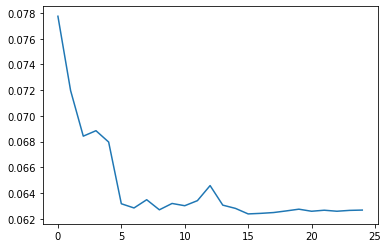

In [36]:
ver = 72
res = (pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(1,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(2,ver)).val_loss.values) / 3

# 5x1e-3, 10x2e-4, 7x2e-5, 3x5e-6
print(res)

plt.plot(res)

[0.08195003 0.06692202 0.0669104  0.06752611 0.06747011 0.06349338
 0.0626976  0.06288502 0.0625446  0.0630336  0.06283608 0.06253493
 0.06272242 0.06274802 0.06280114 0.06248627 0.06244163 0.06259594
 0.06235557 0.06252688 0.06237031 0.06266632 0.0624724  0.0625555
 0.06249723]


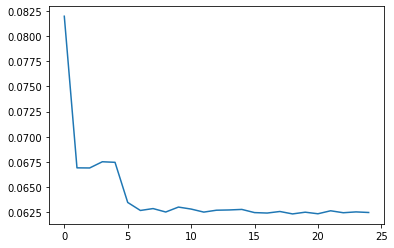

In [37]:
ver = 73
res = (pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(1,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(2,ver)).val_loss.values) / 3

# 5x1e-3, 10x2e-4, 7x2e-5, 3x5e-6
print(res)

plt.plot(res)

[0.07336126 0.06791653 0.06672474 0.06621773 0.06522342 0.06269679
 0.06271483 0.06261532 0.06283813 0.06239797 0.06266095 0.06256483
 0.06280528 0.0622756  0.062841   0.0622916  0.06234851 0.06230284
 0.06239877 0.06240432 0.06237384 0.06242769 0.06245325 0.06240852
 0.06238066]


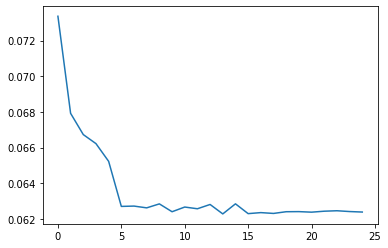

In [36]:
ver = 74
res = (pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(1,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(2,ver)).val_loss.values) / 3

# 5x1e-3, 10x2e-4, 7x2e-5, 3x5e-6
print(res)

plt.plot(res)

[0.08759543 0.07350885 0.07103133 0.06781943 0.08776392 0.06386395
 0.06370772 0.06874262 0.06357561 0.06322936 0.06313038 0.06307746
 0.06421412 0.06311881 0.06331547 0.06188674 0.06199789 0.06180143
 0.06188602 0.06173918 0.06189277 0.06183202 0.06190042 0.06189958
 0.06188536]


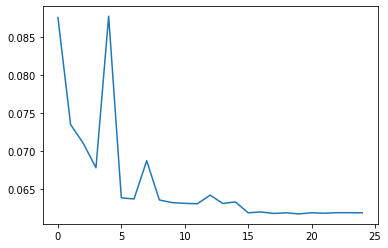

In [37]:
ver = 75
res = (pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(1,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(2,ver)).val_loss.values) / 3

# 5x1e-3, 10x2e-4, 7x2e-5, 3x5e-6
print(res)

plt.plot(res)

In [80]:
predictions.shape

(6494, 60, 6)

In [81]:
predictions.mean((0,1))

array([0.09629448, 0.02383027, 0.0463406 , 0.0402737 , 0.04893126,
       0.05532886], dtype=float32)

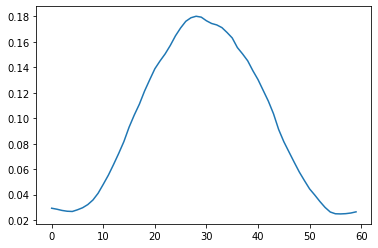

In [38]:
plt.plot(predictions.mean(0)[:,0])

# OOF

In [38]:
def oof_one(num_iter=1, bs=100, fold=0):
    
    st0 = time.time()
    
    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch, 'iters starting now:', num_iter)
    
    setSeeds(SEED + cur_epoch)
    
    val_ds = RSNA_DataSet(ids_df, mode='valid', bs=bs, fold=fold)
    
    loader_val = D.DataLoader(val_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                              shuffle=True)
    print('dataset valid:', len(val_ds), 'loader valid:', len(loader_val))
    
    #model = TabularModel(n_cont = len(meta_cols), feat_sz=feat_sz, fc_drop_p=0)
    model = ResNetModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    else:
        print('starting from scratch')
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)
    
    loc_data = val_ds.metadata.copy()
    series_counts = loc_data.index.value_counts()
    
    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx1'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    preds = []
    
    for i in range(num_iter):
        
        val_ds.setFeats(-1)

        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(val_loop_fn, loader_val)
            predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
            indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
            offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
        else:
            predictions, indices, offsets = val_loop_fn(model, loader_val, device)

        predictions = predictions[np.argsort(indices)]
        offsets = offsets[np.argsort(indices)]
        assert len(predictions) == len(loc_data.index.unique())
        assert len(predictions) == len(offsets)
        assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))

        val_results = []
        for k, series in enumerate(np.sort(loc_data.index.unique())):
            cnt = series_counts[series]
            assert (offsets[k] + cnt) <= 60
            val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])

        val_results = np.concatenate(val_results)
        assert np.isnan(val_results).sum() == 0
        val_results = val_results[loc_data.my_order]
        assert np.isnan(val_results).sum() == 0
        assert len(val_results) == len(loc_data)
        
        preds.append(val_results)

        lls = [log_loss(loc_data[all_ich[k]].values, val_results[:,k], eps=1e-7, labels=[0,1])\
               for k in range(6)]
        ll = (class_weights * np.array(lls)).mean()
        cor = np.corrcoef(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))[0,1]
        auc = roc_auc_score(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))

        print('ver {}, iter {}, fold {}, val ll: {:.4f}, cor: {:.4f}, auc: {:.4f}'
              .format(VERSION, i, fold, ll, cor, auc))
    
    print('total running time', time.time() - st0)
    
    return np.stack(preds)

In [39]:
stg = time.time()
for fold in range(3):
    predictions = oof_one(num_iter=8, bs=bs, fold=fold)
    pickle.dump(predictions, open(PATH_WORK/'oof_{}_f{}_v{}'.format(dataset_name, fold, VERSION),'wb'))
print('total time', time.time() - stg)

completed epochs: 25 iters starting now: 8
adding dummy serieses 168
DataSet 4 valid size 6656 fold 0
dataset valid: 6656 loader valid: 208
loading model model.b25.f0.v75
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 3.773 time per batch: 0.943
Batch 8 device: xla:1 time passed: 5.447 time per batch: 0.681
Batch 12 device: xla:1 time passed: 7.495 time per batch: 0.625
Batch 16 device: xla:1 time passed: 9.487 time per batch: 0.593
Batch 20 device: xla:1 time passed: 11.495 time per batch: 0.575
Batch 24 device: xla:1 time passed: 13.558 time per batch: 0.565
ver 75, iter 0, fold 0, val ll: 0.0635, cor: 0.8425, auc: 0.9882
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 3.630 time per batch: 0.907
Batch 8 device: xla:1 time passed: 5.265 time per batch: 0.658
Batch 12 device: xla:1 time passed: 7.289 time per batch: 0.607
Batch 16 device: xla:1 time passed: 9.299 time per batch: 0.581
Batch 20 device: xla:1 time passed: 11.367 time per batch: 0.568
Batch 24 

Batch 4 device: xla:1 time passed: 3.795 time per batch: 0.949
Batch 8 device: xla:1 time passed: 5.458 time per batch: 0.682
Batch 12 device: xla:1 time passed: 7.462 time per batch: 0.622
Batch 16 device: xla:1 time passed: 9.462 time per batch: 0.591
Batch 20 device: xla:1 time passed: 11.447 time per batch: 0.572
Batch 24 device: xla:1 time passed: 13.485 time per batch: 0.562
ver 75, iter 0, fold 2, val ll: 0.0602, cor: 0.8437, auc: 0.9896
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 3.720 time per batch: 0.930
Batch 8 device: xla:1 time passed: 5.272 time per batch: 0.659
Batch 12 device: xla:1 time passed: 7.328 time per batch: 0.611
Batch 16 device: xla:1 time passed: 9.335 time per batch: 0.583
Batch 20 device: xla:1 time passed: 11.339 time per batch: 0.567
Batch 24 device: xla:1 time passed: 13.339 time per batch: 0.556
ver 75, iter 1, fold 2, val ll: 0.0602, cor: 0.8437, auc: 0.9896
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 3.598 time per 

In [ ]:
# correlation between models
# scores per slice
# what is the best way to agg oof, model\run levels
# best aggregation theoretically
# distribution of oof preds
# score - what uniform p will get
# 0.5 + np.sign(x-0.5) *2*(x-0.5)**2 - makes it less aggressive, is it a good transform above mean?
# does scaling help for single runs, or is it aggregation artifact.

# s101 problem.
    # maybe 8 and 32 behave differently

## Selecting runs aggregation

In [21]:
afuncs_names = np.array(['mean','gmean','q50','q25','q75','psig'])

def scalePreds(x, power = 2):
    return (0.5 + np.sign(x-0.5)*0.5*np.abs(2*x-1)**power)

def applyAggFunc(probs, func_name, axis=1, norm_axis=None):
    
    st = time.time()
    
    if func_name == 'mean':
        res = probs.mean(axis)
    elif func_name == 'max':
        res = probs.max(axis)
    elif func_name == 'min':
        res = probs.min(axis)
    elif func_name == 'gmean':
        res = np.exp(np.log(probs).mean(axis))
    elif func_name == 'q50':
        res = np.quantile(probs,q=0.5,axis=axis)
    elif func_name == 'q25':
        res = np.quantile(probs,q=0.25,axis=axis)
    elif func_name == 'q75':
        res = np.quantile(probs,q=0.75,axis=axis)
    elif func_name == 'psig':
        mask_zero = (probs >= 1).sum(axis) > 0
        res = 1 / (1 + np.exp(-(np.log(probs/(1-probs), where=(probs < 1)).mean(axis))))
        res[mask_zero] = 0
    else:
        assert True
    
    res = np.clip(res, 1e-15, 1-1e-15)
    
    #print('applying time', func_name, time.time()-st)
    return res

In [22]:
np.set_printoptions(precision=5)

for fold in range(3):
    print('fold', fold)
    data_fold = ids_df.loc[ids_df.fold == fold]

    preds = np.stack([pickle.load(open(PATH_WORK/'oof_{}_f{}_v{}'.format(name, fold, ver),'rb')) \
        for name, ver in zip(['Densenet161','Densenet169','Densenet201','se_resnext101_32x4d'], [72,73,74,75])])

    assert len(data_fold) == preds.shape[2]
    
    preds = np.clip(preds, 1e-15, 1-1e-15)
    for afunc in afuncs_names:
        apreds = applyAggFunc(preds, afunc)
        res = ((- data_fold[all_ich].values * np.log(apreds) - (1 - data_fold[all_ich].values) * np.log(1 - apreds))\
            * class_weights).mean((1,2))
        roc = [roc_auc_score(data_fold[all_ich].values.reshape(-1), apreds[i].reshape(-1)) for i in range(4)]
        print('{:7s} {} {}'.format(afunc,res,np.array(roc)))

fold 0
mean    [0.06301 0.063   0.06301 0.06244] [0.98803 0.98826 0.98836 0.98862]
gmean   [0.06313 0.06312 0.06314 0.06259] [0.98802 0.98824 0.98835 0.98861]
q50     [0.06328 0.06324 0.06325 0.06272] [0.98798 0.9882  0.98831 0.98858]
q25     [0.06382 0.06382 0.06382 0.06339] [0.98793 0.98808 0.98824 0.98847]
q75     [0.06326 0.06318 0.06308 0.06286] [0.988   0.98825 0.98836 0.98857]
psig    [0.06315 0.06313 0.06314 0.06261] [0.98803 0.98824 0.98835 0.98861]
fold 1
mean    [0.06242 0.06224 0.06224 0.06109] [0.98841 0.98822 0.98825 0.98864]
gmean   [0.06251 0.06238 0.06235 0.06131] [0.9884  0.9882  0.98822 0.98857]
q50     [0.06269 0.06246 0.06247 0.06141] [0.98836 0.98817 0.98817 0.98851]
q25     [0.06298 0.06313 0.06298 0.06223] [0.9883  0.98806 0.98806 0.98835]
q75     [0.06304 0.06233 0.06245 0.06143] [0.98838 0.9882  0.98823 0.98863]
psig    [0.06259 0.06239 0.06246 0.06131] [0.9884  0.9882  0.98819 0.98857]
fold 2
mean    [0.05989 0.06022 0.06001 0.05902] [0.98938 0.98931 0.98954 

In [29]:
preds_all = np.zeros((preds.shape[0],preds.shape[1],len(ids_df),preds.shape[3]))

for fold in range(3):
    preds = np.stack([pickle.load(open(PATH_WORK/'oof_{}_f{}_v{}'.format(name, fold, ver),'rb')) \
        for name, ver in zip(['Densenet161','Densenet169','Densenet201','se_resnext101_32x4d'], [72,73,74,75])])
    
    preds = np.clip(preds, 1e-15, 1-1e-15)
    
    preds_all[:,:,ids_df.fold == fold,:] = preds

In [38]:
((- ids_df[all_ich].values * np.log(preds_all) 
  - (1 - ids_df[all_ich].values) * np.log(np.clip(1 - preds_all,1e-15,1-1e-15)))
 * class_weights).mean((1,2,3))

array([0.06268, 0.06259, 0.06246, 0.06198])

In [39]:
((- ids_df[all_ich].values * np.log(preds_all.mean(1)) 
  - (1 - ids_df[all_ich].values) * np.log(np.clip(1 - preds_all.mean(1),1e-15,1-1e-15)))
 * class_weights).mean((1,2))

array([0.06177, 0.06182, 0.06176, 0.06085])

In [31]:
runs_afunc = 'mean'
preds2 = applyAggFunc(preds_all, runs_afunc)

## Selecting models aggregation

In [68]:
for afunc in afuncs_names:
    #print(afunc)
    apreds = applyAggFunc(preds2, afunc, axis=0)
    res = ((- ids_df[all_ich].values * np.log(apreds) - (1 - ids_df[all_ich].values) * np.log(1 - apreds))\
        * class_weights).mean()
    
    if True:
        best_score = res
        best_k = 0
        for k in range(1,50):
            apreds2 = scalePreds(apreds, 1.0 + 0.01 * k)
            apreds2 = np.clip(apreds2, 1e-15, 1-1e-15)

            res2 = ((- ids_df[all_ich].values * np.log(apreds2) - (1 - ids_df[all_ich].values) * np.log(1 - apreds2))\
                    * class_weights).mean()

            if res2 > best_score: break
            best_score = res2
            best_k = k

        print('{:7s} {:5f}   {:2f} {:5f}'.format(afunc,res,1+0.01*best_k,best_score))
    else:
        print('{:7s} {:5f}'.format(afunc,res))

mean    0.059085   1.130000 0.058993
gmean   0.059406   1.240000 0.059135
q50     0.059532   1.230000 0.059280
q25     0.060557   1.400000 0.059908
q75     0.059834   1.090000 0.059781
psig    0.059423   1.250000 0.059121


In [69]:
apreds = (preds2*np.array([0.25,0.25,0.25,0.25])[:,None,None]).sum(0)
((- ids_df[all_ich].values * np.log(apreds) - (1 - ids_df[all_ich].values) * np.log(1 - apreds))\
        * class_weights).mean()

0.05908490515986469

In [70]:
apreds = (preds2*np.array([0.2,0.2,0.2,0.4])[:,None,None]).sum(0)
((- ids_df[all_ich].values * np.log(apreds) - (1 - ids_df[all_ich].values) * np.log(1 - apreds))\
        * class_weights).mean()

0.05900441267604068

In [73]:
models_afunc = 'mean'

## Scaling

In [86]:
preds_all.shape

(4, 8, 674252, 6)

In [88]:
res = ((- ids_df[all_ich].values * np.log(preds_all) 
  - (1 - ids_df[all_ich].values) * np.log(np.clip(1 - preds_all,1e-15,1-1e-15)))
 * class_weights).mean()

In [87]:
((- ids_df[all_ich].values * np.log(preds_all) 
  - (1 - ids_df[all_ich].values) * np.log(np.clip(1 - preds_all,1e-15,1-1e-15)))
 * class_weights).mean((1,2,3))

array([0.06268, 0.06259, 0.06246, 0.06198])

In [ ]:
best_score = res
best_k = 0
for k in range(1,50):
    apreds = scalePreds(preds_all, 1.0 + 0.01 * k)
    apreds = np.clip(apreds, 1e-15, 1-1e-15)

    res2 = ((- ids_df[all_ich].values * np.log(apreds) - (1 - ids_df[all_ich].values) * np.log(1 - apreds))\
            * class_weights).mean()

    if res2 > best_score: break
    best_score = res2
    best_k = k

print('{{:5f}   {:2f} {:5f}'.format(res,1+0.01*best_k,best_score))

## Models behavior per groups

In [41]:
for col in cols_le:
    for i in ids_df[col].unique():
        res = ((- ids_df[all_ich].values * np.log(preds_all.mean(1)) - (1 - ids_df[all_ich].values) \
                * np.log(1 - preds_all.mean(1))) * class_weights)[:,(ids_df[col] == i)].mean((1,2))
        sz = (ids_df[col] == i).sum()
        sz_test = (test_md[col] == i).sum()
        print('{:20s} {:2d} {:6d} {:6d} {}'.format(col,i,sz,sz_test,res))

WindowCenter_1_le     0 248151   2157 [0.03705 0.03668 0.03694 0.03659]
WindowCenter_1_le     2  10377     34 [0.11658 0.11467 0.11616 0.11358]
WindowCenter_1_le     3 341674  75369 [0.06421 0.06464 0.06441 0.06327]
WindowCenter_1_le     1  70894    985 [0.12686 0.1265  0.12643 0.12507]
WindowCenter_1_le     4   3156      0 [0.09964 0.10669 0.09404 0.08973]
BitType_le            1 323550   3088 [0.05729 0.05701 0.057   0.0565 ]
BitType_le            0 338723  75369 [0.06359 0.06402 0.06378 0.06264]
BitType_le            2   2252     60 [0.12916 0.126   0.13457 0.12131]
BitType_le            4   6776     28 [0.13046 0.12838 0.13103 0.12605]
BitType_le            3   2951      0 [0.13481 0.13559 0.1363  0.13621]
WindowCenter_0_le     1 248151   2157 [0.03705 0.03668 0.03694 0.03659]
WindowCenter_0_le     4  10343     34 [0.11679 0.11483 0.1163  0.11368]
WindowCenter_0_le     2 151196   2148 [0.12164 0.12159 0.12156 0.11969]
WindowCenter_0_le     0 213404  69272 [0.03548 0.03606 0.03585 0

## Standard deviation analysis

In [42]:
stds = preds_all.std(1)

In [43]:
stds.mean((1))

array([[0.00673, 0.00077, 0.00338, 0.00226, 0.00435, 0.00447],
       [0.0062 , 0.00074, 0.00314, 0.00204, 0.00397, 0.00386],
       [0.0059 , 0.00073, 0.00294, 0.00195, 0.00365, 0.00395],
       [0.00766, 0.00075, 0.0039 , 0.00263, 0.00479, 0.00472]])

In [45]:
stds.shape

(4, 674252, 6)

In [50]:
for i in range(6):
    idx = stds[0,:,i].argmax()
    print(preds_all[0,:,idx,i])

[0.8527  0.05913 0.05106 0.08638 0.84558 0.05423 0.07018 0.84259]
[0.17928 0.70484 0.13346 0.3709  0.11267 0.75836 0.78877 0.83044]
[0.74571 0.01364 0.01121 0.01677 0.75372 0.01375 0.01258 0.76661]
[0.74808 0.00857 0.74761 0.10039 0.73221 0.00924 0.02616 0.08939]
[0.19123 0.08033 0.65973 0.07672 0.1776  0.08611 0.73698 0.8015 ]
[0.64336 0.81652 0.28427 0.61186 0.62909 0.28193 0.28955 0.83129]


In [51]:
for i in range(6):
    idx = stds[3,:,i].argmax()
    print(preds_all[3,:,idx,i])

[0.98124 0.97982 0.18154 0.16633 0.14569 0.19571 0.99596 0.99338]
[0.55692 0.10884 0.20442 0.59746 0.09779 0.0987  0.10347 0.37919]
[0.91611 0.87244 0.01683 0.02782 0.85069 0.90538 0.91419 0.05308]
[0.7601  0.16606 0.07542 0.83273 0.06887 0.88932 0.01933 0.82366]
[0.23019 0.69766 0.20732 0.14846 0.63866 0.85328 0.12059 0.88527]
[0.84319 0.03652 0.81045 0.85523 0.8237  0.67587 0.13533 0.77968]


In [58]:
((- preds_all.mean(1, keepdims=True) * np.log(preds_all) 
  - (1 - preds_all.mean(1, keepdims=True)) * np.log(np.clip(1 - preds_all,1e-15,1-1e-15)))
 * class_weights).mean((1,2))

array([[0.14442, 0.00942, 0.03493, 0.02353, 0.05386, 0.06121],
       [0.14628, 0.01031, 0.0354 , 0.02395, 0.05451, 0.06016],
       [0.14718, 0.00941, 0.03481, 0.02377, 0.05303, 0.06166],
       [0.14496, 0.01316, 0.03619, 0.02431, 0.05454, 0.06067]])

In [59]:
((- preds_all.mean(1, keepdims=True) * np.log(preds_all) 
  - (1 - preds_all.mean(1, keepdims=True)) * np.log(np.clip(1 - preds_all,1e-15,1-1e-15)))
 * class_weights).mean((1,2,3))

array([0.05456, 0.0551 , 0.05498, 0.05564])

In [66]:
((- preds_all.mean((1,2), keepdims=True) * np.log(preds_all) 
  - (1 - preds_all.mean((1,2), keepdims=True)) * np.log(np.clip(1 - preds_all,1e-15,1-1e-15)))
 * class_weights).mean((1,2,3))

array([0.60433, 0.60165, 0.59444, 0.60381])

# Inference

In [40]:
def inference_one(bs = 100, add_seed = 0, fold = 0, anum = 0):
    st = time.time()

    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch)

    #model = TabularModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    model = ResNetModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)

    setSeeds(SEED + cur_epoch + add_seed)

    tst_ds = RSNA_DataSet(test_md, mode='test', bs=bs, fold=fold)
    loader_tst = D.DataLoader(tst_ds, num_workers=8 if CLOUD else 0, batch_size=bs, shuffle=False)
    print('dataset test:', len(tst_ds), 'loader test:', len(loader_tst))
    
    tst_ds.setFeats(anum)

    loc_data = tst_ds.metadata.copy()
    series_counts = loc_data.index.value_counts()

    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx1'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    if CLOUD and (not CLOUD_SINGLE):
        results = model_parallel(test_loop_fn, loader_tst)
        predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
        indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
        offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
    else:
        predictions, indices, offsets = test_loop_fn(model, loader_tst, device)

    predictions = predictions[np.argsort(indices)]
    offsets = offsets[np.argsort(indices)]
    assert len(predictions) == len(test_md.SeriesInstanceUID.unique())
    assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
    
    val_results = []
    for k, series in enumerate(np.sort(loc_data.index.unique())):
        cnt = series_counts[series]
        assert (offsets[k] + cnt) <= 60
        val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])

    val_results = np.concatenate(val_results)
    assert np.isnan(val_results).sum() == 0
    val_results = val_results[loc_data.my_order]
    assert len(val_results) == len(loc_data)

    print('test processing time:', time.time() - st)
    
    return val_results

In [41]:
preds = []
stg = time.time()
for fold in range(3):
    preds2 = []
    for anum in range(32):
        predictions = inference_one(fold = fold, anum = -1)
        preds2.append(predictions)
    preds.append(np.stack(preds2))
preds = np.stack(preds)
print('total time', time.time() - stg)

pickle.dump(preds, open(PATH_WORK/'preds_{}_v{}'.format(dataset_name, VERSION),'wb'))

completed epochs: 25
loading model model.b25.f0.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 18.719786643981934
completed epochs: 25
loading model model.b25.f0.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 7.524738073348999
completed epochs: 25
loading model model.b25.f0.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 7.300777435302734
completed epochs: 25
loading model model.b25.f0.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 7.019393682479858
completed epochs: 25
loading model model.b25.f0.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, 

test processing time: 6.822573900222778
completed epochs: 25
loading model model.b25.f1.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.7198805809021
completed epochs: 25
loading model model.b25.f1.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.7346508502960205
completed epochs: 25
loading model model.b25.f1.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.6780686378479
completed epochs: 25
loading model model.b25.f1.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.697108507156372
completed epochs: 25
loading model model.b25.f1.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 1
dataset t

test processing time: 6.707979917526245
completed epochs: 25
loading model model.b25.f2.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 2
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.701488733291626
completed epochs: 25
loading model model.b25.f2.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 2
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.694072246551514
completed epochs: 25
loading model model.b25.f2.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 2
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.727868556976318
completed epochs: 25
loading model model.b25.f2.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 2
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.719923257827759
completed epochs: 25
loading model model.b25.f2.v75
adding dummy serieses 186
DataSet 4 test size 2400 fold 2
datase

# Files transfer

In [3]:
!gsutil cp /home/zahar_chikishev/running/preds* gs://rsna-hemorrhage/results
!gsutil cp /home/zahar_chikishev/running/oof* gs://rsna-hemorrhage/results

Copying file:///home/zahar_chikishev/running/preds_Densenet161_v72 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file:///home/zahar_chikishev/running/preds_Densenet169 [Content-Type=application/octet-stream]...
Copying file:///home/zahar_chikishev/running/preds_Densenet169_v51 [Content-Type=application/octet

In [ ]:
!gsutil gs://rsna-hemorrhage/results/* .

In [19]:
!rm /home/zahar_chikishev/running/*v53

In [18]:
!ls /home/zahar_chikishev/running/*v53

/home/zahar_chikishev/running/preds_se_resnext101_32x4d_v53
/home/zahar_chikishev/running/stats.f0.v53
/home/zahar_chikishev/running/stats.f1.v53
/home/zahar_chikishev/running/stats.f2.v53


In [20]:
!ls /home/zahar_chikishev/running/oof*

/home/zahar_chikishev/running/oof_Densenet161_f0_v72
/home/zahar_chikishev/running/oof_Densenet161_f1_v72
/home/zahar_chikishev/running/oof_Densenet161_f2_v72
/home/zahar_chikishev/running/oof_Densenet169_f0_v73
/home/zahar_chikishev/running/oof_Densenet169_f1_v73
/home/zahar_chikishev/running/oof_Densenet169_f2_v73
/home/zahar_chikishev/running/oof_Densenet201_f0_v74
/home/zahar_chikishev/running/oof_Densenet201_f1_v74
/home/zahar_chikishev/running/oof_Densenet201_f2_v74
/home/zahar_chikishev/running/oof_se_resnext101_32x4d_f0_v75
/home/zahar_chikishev/running/oof_se_resnext101_32x4d_f1_v75
/home/zahar_chikishev/running/oof_se_resnext101_32x4d_f2_v75


In [21]:
!ls /home/zahar_chikishev/running/preds*

/home/zahar_chikishev/running/preds_Densenet161_v72
/home/zahar_chikishev/running/preds_Densenet169_v73
/home/zahar_chikishev/running/preds_Densenet201_v74
/home/zahar_chikishev/running/preds_se_resnext101_32x4d_v75


# Submitting

In [51]:
preds = 0.5* (pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet169', 51),'rb')) +
         pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet201', 52),'rb')))

In [53]:
preds = (pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet169', 51),'rb')) +
         pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet201', 52),'rb')) +
         pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('se_resnext101_32x4d', 53),'rb'))) / 3

In [67]:
preds = np.stack([pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet161', 72),'rb')),
                  pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet169', 73),'rb')),
                  pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet201', 74),'rb')),
                  pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('se_resnext101_32x4d', 75),'rb'))])

In [211]:
np.set_printoptions(precision=3)

In [217]:
preds.std(2).mean((1,2))

array([[2.960e-08, 9.020e-10, 9.625e-09, 6.666e-09, 9.995e-09, 1.182e-08],
       [2.924e-08, 9.041e-10, 9.693e-09, 6.750e-09, 1.010e-08, 1.153e-08],
       [2.927e-08, 1.022e-09, 9.434e-09, 6.728e-09, 9.807e-09, 1.187e-08],
       [3.016e-08, 9.835e-10, 9.533e-09, 6.913e-09, 1.039e-08, 1.167e-08]],
      dtype=float32)

In [63]:
((- preds.mean((1,2), keepdims=True) * np.log(np.clip(preds,1e-15,1-1e-15)) 
  - (1 - preds.mean((1,2), keepdims=True)) * np.log(np.clip(1 - preds,1e-15,1-1e-15)))
 * class_weights).mean((1,2,3))

array([[0.15249, 0.01507, 0.03719, 0.02508, 0.05596, 0.06206],
       [0.14765, 0.01445, 0.03652, 0.02455, 0.05567, 0.05837],
       [0.14786, 0.01586, 0.0346 , 0.02439, 0.05371, 0.06038],
       [0.1466 , 0.01732, 0.03613, 0.02529, 0.05583, 0.05959]])

In [65]:
((- preds.mean((1,2,3), keepdims=True) * np.log(np.clip(preds,1e-15,1-1e-15)) 
  - (1 - preds.mean((1,2,3), keepdims=True)) * np.log(np.clip(1 - preds,1e-15,1-1e-15)))
 * class_weights).mean((1,2,3,4))

array([0.54027, 0.54585, 0.53983, 0.54938])

In [189]:
preds = pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('se_resnext101_32x4d', 75),'rb'))

In [191]:
preds.shape

(3, 32, 78545, 6)

In [194]:
predictions = np.quantile(preds,q=0.5,axis=(1)).mean(0)

In [72]:
predictions = preds.mean((0,1,2))

In [73]:
predictions = scalePreds(predictions, 1.13)

In [75]:
test_md['pred_any'] = predictions[:,0]

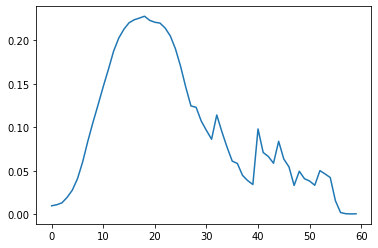

In [76]:
plt.plot(test_md[['pos_idx1','pred_any']].groupby('pos_idx1').mean())

In [89]:
predictions = np.exp(np.log(preds).mean((0,1)))

In [43]:
predictions = 1 / (1 + np.exp(-(np.log(preds/(1-preds)).mean((0,1)))))

In [43]:
predictions = preds.mean((0,1))

In [77]:
predictions.mean(0)

array([0.13095, 0.0056 , 0.04341, 0.03077, 0.04752, 0.05518],
      dtype=float32)

In [57]:
predictions.mean(0)

array([0.1280228 , 0.00678272, 0.04317398, 0.03195811, 0.04593468,
       0.05528003], dtype=float32)

In [78]:
id_column = np.array([a + '_' + b for a in test_md.SOPInstanceUID for b in all_ich])
sub = pd.DataFrame({'ID': id_column, 'Label': predictions.reshape(-1)})

In [79]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.1309477

In [58]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.1281835436820984

In [80]:
best_sub = pd.read_csv(PATH/'submission_061.csv')

In [81]:
best_sub.loc[range(0,len(sub),6), 'Label'].mean()

0.13475628267250392

In [82]:
sub.to_csv(PATH/'sub.csv', index=False)

In [83]:
np.corrcoef(sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'], 
            best_sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'])[0,1]

0.994651700956071

In [63]:
np.corrcoef(sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'], 
            best_sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'])[0,1]

0.9944464662920349

In [84]:
!kaggle competitions submit rsna-intracranial-hemorrhage-detection -f C:/StudioProjects/Hemorrhage/sub.csv -m "TPU, d161+d169+d201+s101, 32TTA, 3folds, mean, scale 1.13"

Successfully submitted to RSNA Intracranial Hemorrhage Detection



  0%|          | 0.00/17.3M [00:00<?, ?B/s]
  0%|          | 8.00k/17.3M [00:00<03:56, 76.7kB/s]
  2%|2         | 384k/17.3M [00:00<02:43, 109kB/s]  
  4%|4         | 752k/17.3M [00:00<01:53, 153kB/s]
  6%|5         | 984k/17.3M [00:00<01:20, 213kB/s]
  7%|6         | 1.19M/17.3M [00:00<00:57, 291kB/s]
  8%|8         | 1.38M/17.3M [00:00<00:43, 383kB/s]
  9%|9         | 1.56M/17.3M [00:02<01:29, 185kB/s]
 11%|#1        | 1.91M/17.3M [00:03<01:02, 259kB/s]
 13%|#2        | 2.22M/17.3M [00:03<00:44, 357kB/s]
 15%|#4        | 2.53M/17.3M [00:03<00:31, 487kB/s]
 16%|#6        | 2.84M/17.3M [00:03<00:23, 652kB/s]
 18%|#8        | 3.13M/17.3M [00:03<00:17, 853kB/s]
 20%|#9        | 3.44M/17.3M [00:03<00:13, 1.09MB/s]
 22%|##1       | 3.72M/17.3M [00:03<00:10, 1.32MB/s]
 23%|##3       | 4.02M/17.3M [00:03<00:08, 1.60MB/s]
 25%|##5       | 4.34M/17.3M [00:03<00:07, 1.89MB/s]
 27%|##6       | 4.64M/17.3M [00:03<00:06, 2.11MB/s]
 29%|##8       | 4.95M/17.3M [00:04<00:05, 2.34MB/s]
 31%|###1    